# Explorative Data Analysis
In this notebook we will import the dataset from [Kaggle - Zillow Prize](https://www.kaggle.com/c/zillow-prize-1/data) and prepare it for prediction!

## Problem definition
The problem definition
works as the driving force for a data analysis plan execution. 

How can we assess the value of a house, or better, the **sale price**? The short answer is we cannot, since the database is not made for that. However, we can predict the log-error.

$logerror = \log(Zestimate)-\log(SalePrice)$

Now, it is easier to understand what our real goal is: **predicting a number through regression**. This is something we know how to do!

### Understand the context: hosing-market in the west coast of the U.S.A.
Other than finding links between features, we need to point out some factors we cannot easily include when making our predictions.

We are given a "full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016 and 2017", What problems are we facing now?
1. We are focusing on a particular geographical area, which we are not familiar with;
2. We are focusing on a market we have no prior domain-knowledge of;
3. There is no price sale in the dataset.

Therefore, we have not a clue of how the market is going for houses there, nor we know what gets a house to a particular sale price (the weight of each feature). While the first can be hardly tracked,
we can find out about the latter two through data exploration and domain research.

As we know, datasets rarely are perfect, so we must perform some *magic* to make it usable with our
regression algorithms and find out useful information!


### Need for a clean & clear dataset
What do we need to do to achieve a **clean dataset**?

The following approach allows us to use a vast variety of cleaning and feature engineering strategies to converge to a perfect training dataset.

1. Basic Exploration
2. Data Cleaning & Feature Engineering
3. Modeling
4. Export

However, we will not follow a linear approach. We will improve the quality of the dataset as soon as we have the chance

## Step 1: Basic Exploration
First of all, we need to import our data and set up our environment

In this step, we define the sources of data, define data schemas
and tables, understand the main characteristics of the data.

The golden rule here is not to touch the dataset!

### Importing all the dependencies (just in case)

In [84]:
dependencies = ['pandas', 'numpy', 'missingno', 'seaborn', 'folium', 'sklearn', 'matplotlib', 'datetime','xgboost', 'lightgbm']
for i in dependencies:
    !pip install {i}

### Environment & Global Imports

In [85]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import folium
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from math import floor, ceil

color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.style.use('ggplot')
%matplotlib inline
# It's important to set it up before anything

### Data Loading
Load the data, merge the years together and check out its shape

In [86]:
# DataFrame downloaded and splitted into properties and train for 2016 and 2017 

def load_merge_proptrain(dataset1, dataset2, predicate):
    properties = pd.read_csv(dataset1, low_memory = False)
    train = pd.read_csv(dataset2, low_memory = False)
    # Let's merge the respective years 
    merged = pd.merge(properties, train, how = 'inner', on = predicate)
    return merged


data2016 = load_merge_proptrain("Data/properties_2016.csv", "Data/train_2016_v2.csv", 'parcelid')
data2017 = load_merge_proptrain("Data/properties_2017.csv", "Data/train_2017.csv", 'parcelid')

Now, we have two choices
* Merge them together
    * Can complicate the learning process
* Use the 2017 data to test our cleaning and feature engineering process
    * We will still perform the same computations on both datasets
    
We keep them separated for now.

In [87]:
# Shape
print(f'Shape of data2016 is:\t {data2016.shape}')
print(f'Shape of data2017 is:\t {data2017.shape}')

Shape of data2016 is:	 (90275, 60)
Shape of data2017 is:	 (77613, 60)


### Step 1.1 Basic Info

Let's find out some basic information about out dataset, such as:
* Memory usage
* Total count of entries (rows)
* What features are present (columns)

In [88]:
#Print avoiding Notebook Flood
print('2016 House Dataset')
print('============================================================')
data2016.info(verbose=False)

print('\n2017 House Dataset')
print('============================================================')
data2017.info(verbose=False)

print('\n\n2016 House Dataset Shape')
print('============================================================')
print(data2016.shape)
print('\n2017 House Dataset Shape')
print('============================================================')
print(data2017.shape)

2016 House Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to transactiondate
dtypes: float64(53), int64(1), object(6)
memory usage: 42.0+ MB

2017 House Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Columns: 60 entries, parcelid to transactiondate
dtypes: float64(53), int64(1), object(6)
memory usage: 36.1+ MB


2016 House Dataset Shape
(90275, 60)

2017 House Dataset Shape
(77613, 60)


In [89]:
data2016.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.027500e+04,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,6856.000000,89614.000000,85596.000000,33.000000,3564.000000,6856.000000,421.000000,90275.000000,9607.000000,89093.000000,29937.000000,29937.000000,56080.000000,9.027500e+04,9.027500e+04,8.012500e+04,17901.0,969.000000,1161.0,1204.0,16697.0,90275.000000,9.027500e+04,88472.000000,90275.000000,36012.000000,90240.000000,90275.000000,43.0,12009.000000,299.000000,58353.000000,2646.000000,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04,90275.000000
mean,1.298466e+07,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,66.0,1347.974037,1773.185987,1745.454531,1404.545455,2380.090067,1355.546674,2302.546318,6048.870551,1.187884,2.241231,1.812005,345.521228,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,1.0,519.827657,1.0,1.0,1.0,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,7.0,1.008743,6.010033,1.110414,310.142101,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13,0.011457
std,2.504510e+06,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,0.0,652.399026,928.162393,909.941166,110.108211,1068.207182,673.703488,1346.255242,20.663461,0.484173,0.963142,0.608761,267.015918,3.684382,2.649654e+05,3.606032e+05,1.217213e+05,0.0,155.054210,0.0,0.0,0.0,5.182901,2.050549e+05,46672.393863,805.694842,166228.910572,3661.339094,2.819627,0.0,0.100830,0.437235,0.797235,216.721869,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11,0.161079
min,1.071174e+07,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,44.000000,2.000000,2.000000,1056.000000,560.000000,44.000000,257.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,1.0,28.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,25.000000,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13,-4.605000
25%,1.155950e+07,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,938.000000,1184.000000,1172.000000,1392.000000,1648.000000,938.000000,1112.000000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381154e+07,-1.184117e+08,5.703000e+03,1.0,420.000000,1.0,1.0,1.0,261.000000,6.037320e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,180.000000,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13,-0.025300
50%,1.254734e+07,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,1244.000000,1540.000000,1518.000000,1440.000000,2104.500000,1248.000000,2028.000000,6037.000000,1.000000,2.000000,2.000000,433.000000,2.000000,3.402150e+07,-1.181734e+08,7.200000e+03,1.0,500.000000,1.0,1.0,1.0,261.000000,6.037620e+07,25218.0

In [90]:
data2017.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,6037.000000,77378.000000,73923.000000,42.000000,3027.000000,6037.000000,386.000000,77579.000000,8289.000000,76963.000000,25520.000000,25520.000000,49571.000000,7.757900e+04,7.757900e+04,6.932100e+04,16174.0,869.000000,465.0,1074.0,15079.0,77579.000000,7.757900e+04,76107.000000,77579.000000,30974.000000,77529.000000,77579.000000,50.0,10106.000000,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,7.746400e+04,7.757800e+04,77579.0,7.757700e+04,77574.000000,2900.000000,7.733200e+04,77613.000000
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,1366.165314,1784.935421,1760.284553,1388.761905,2354.491245,1381.388935,2082.500000,6048.814151,1.191217,2.250107,1.815282,350.047061,3.921749,3.400837e+07,-1.182037e+08,2.997344e+04,1.0,517.930955,1.0,1.0,1.0,261.824476,6.049124e+07,33683.055107,2534.514933,187725.110544,96586.692812,1.476276,7.0,1.009598,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,1.892811e+05,4.901506e+05,2016.0,3.011515e+05,5995.961788,14.088276,6.049667e+13,0.016755
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,670.701336,954.250373,934.352566,122.220874,1186.985442,725.792665,1240.382784,20.747252,0.490980,0.966492,0.588340,261.646070,3.594780,2.652873e+05,3.594085e+05,1.233050e+05,0.0,156.569664,0.0,0.0,0.0,5.141596,2.058962e+05,47211.780350,801.447913,165045.086058,3793.552065,2.823686,0.0,0.118572,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,2.304107e+05,6.537979e+05,0.0,4.927249e+05,7628.859728,2.181281,1.533339e+12,0.170887
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,8.417925e+04,2.068985e+05,2016.0,8.529300e+04,2712.630000,14.000000,6.037311e+13,-0.024325
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000000,1259.000000,1812.500000,6037.000000,1.000000,2.000000,2.000000,436.000000,2.000000,3.402200e+07,-1.181810e+08,7.206000e+03,1.0,500.000000,1.0,1.0,1.0,2

### Step 1.2 Check data types & Study Categorical Features

We have found out that *float64(53), int64(1), object(6)*

Let's analyze the 6 objects first.

In [91]:
data2016.select_dtypes(include = 'object').columns
# data2017.select_dtypes(include = 'object').columns

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag', 'transactiondate'],
      dtype='object')

##### Step 1.2.1 Categorical 

Quick fixes that we can take into account are:
* Convert `transactiondate` into a format that is better fit
* Encode `hashottuborspa`, `fireplaceflag`
    * Add new feature `hashottub`, a number either 0 or 1
    * Add new feature `hasspa`, a number either 0 or 1
    * Add new feature `hasfireplace`, a number either 0 or 1
    * remove `hashottuborspa`
* Consider using the different labels of `propertyzoningdesc` for prediction
    * Might fill the missing values with KNN
* `taxdelinquencyflag`, `propertycountylandusecode`, `propertyzoningdesc` could be helpful but we still need to see their missing values rates


##### Step 1.2.2 Numerical

While for the numerical features, we can consider these options:
* Convert all the float64 to float32, for faster computation.
    * To avoid losing information we can rescale the data and then convert it all, so the change will be uniform
* Convert int64 to float32, if it makes sense
    * Remember we cannot say there is 1.5 pools in a house!

Before taking any decision we have to study the correlations and the missing values rate.

### Step 1.3 Correlation

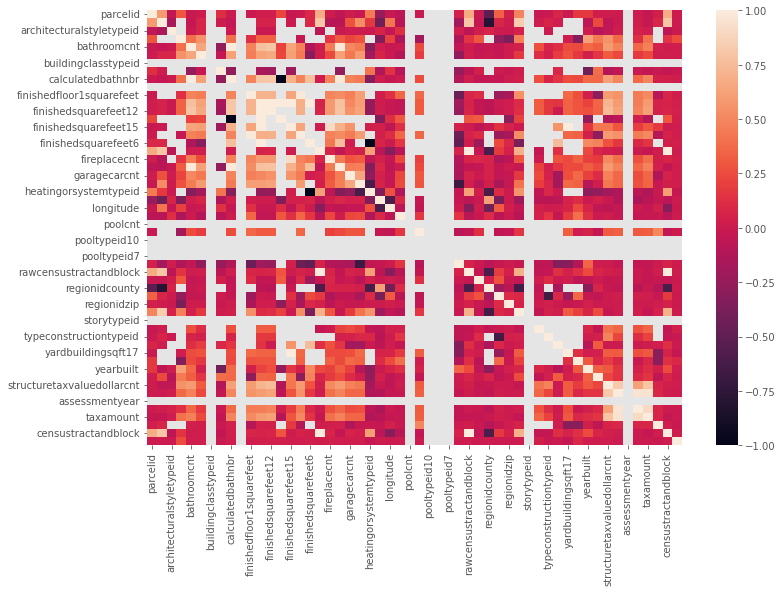

<Figure size 432x288 with 0 Axes>

In [92]:
def numeric_heatmap(df, col_type):
    plt.figure(figsize = (12,8))
    sns.heatmap(data=df.select_dtypes(include=col_type).corr())
    plt.show()
    plt.gcf().clear()
    pass

cols = ['float64','int64'] #choose the type you want to see
numeric_heatmap(data2016, cols)

### Step 1.4:  Identify Missing Values

Here, we identify feature with more than 90% missing values.
* If they are categorical, we need to carefully study them
* If they are numerical, it feels more reasonable to drop them. Else they will be in the way of the estimation.

Let's start by visualizing those features and then drop some of them.

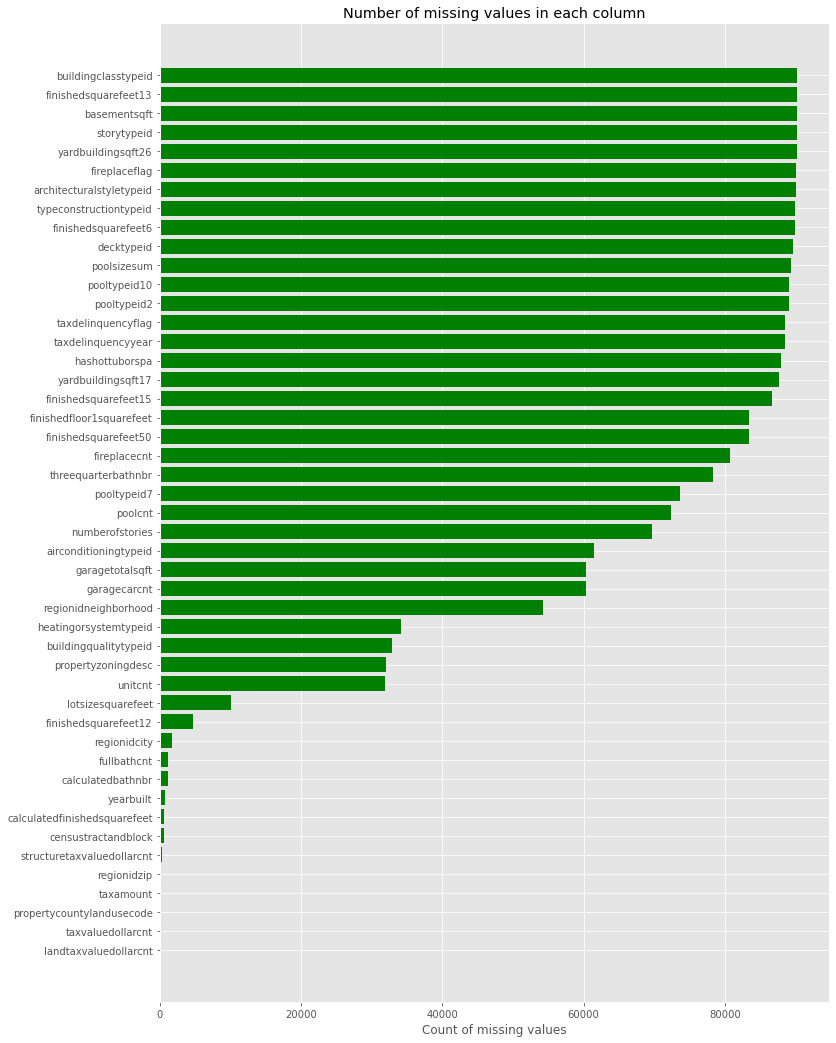

In [93]:
def missing_values_barplot(dataset):
    missing_df = dataset.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    # missing_df = dataset.isnull().sum(axis = 0) * 100 / len(dataset)
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='green')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()
    pass

missing_values_barplot(data2016)

In [94]:
#missing_values_barplot(data2017)

In [95]:
missing_ratio = data2016.isna().sum().sort_values(ascending = False)/len(data2016)
missing_ratio

buildingclasstypeid             0.999823
finishedsquarefeet13            0.999634
basementsqft                    0.999524
storytypeid                     0.999524
yardbuildingsqft26              0.998948
fireplaceflag                   0.997541
architecturalstyletypeid        0.997109
typeconstructiontypeid          0.996688
finishedsquarefeet6             0.995336
decktypeid                      0.992711
poolsizesum                     0.989266
pooltypeid10                    0.987139
pooltypeid2                     0.986663
taxdelinquencyyear              0.980249
taxdelinquencyflag              0.980249
hashottuborspa                  0.973802
yardbuildingsqft17              0.970690
finishedsquarefeet15            0.960521
finishedsquarefeet50            0.924054
finishedfloor1squarefeet        0.924054
fireplacecnt                    0.893581
threequarterbathnbr             0.866973
pooltypeid7                     0.815043
poolcnt                         0.801706
numberofstories 

We understand now that we have three kinds of problems here:
* Missing more than 89%
    * Probably best to drop, unless they are categorical
* Missing more than 40%
    * Could be time for some feature engineering 
    * Can be filled artificially
* Missing 10% or less
    * Can be filled artificially

The first thing to is to drop some data, which might be in our way to predict the logerror. Too many feature become difficult to handle.

##### Step 1.4.1 Removing features that miss 89% of data or more

In [96]:
to_drop = missing_ratio[missing_ratio>=0.89].index.tolist()
data2016[to_drop].dtypes

buildingclasstypeid         float64
finishedsquarefeet13        float64
basementsqft                float64
storytypeid                 float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet6         float64
decktypeid                  float64
poolsizesum                 float64
pooltypeid10                float64
pooltypeid2                 float64
taxdelinquencyyear          float64
taxdelinquencyflag           object
hashottuborspa               object
yardbuildingsqft17          float64
finishedsquarefeet15        float64
finishedsquarefeet50        float64
finishedfloor1squarefeet    float64
fireplacecnt                float64
dtype: object

We will follow the strategy as stated before for every object present here, apart from `taxdelinquencyflag` which needs to be encoded.

NA values in each variable means that there is no fireplace/hot tub(spa) and property taxes for this parcel are not past due as of 2015. That is, NA is **unique category** in those variables.

Just to be sure, let's plot a heat map to see if there is a pattern we can exploit!

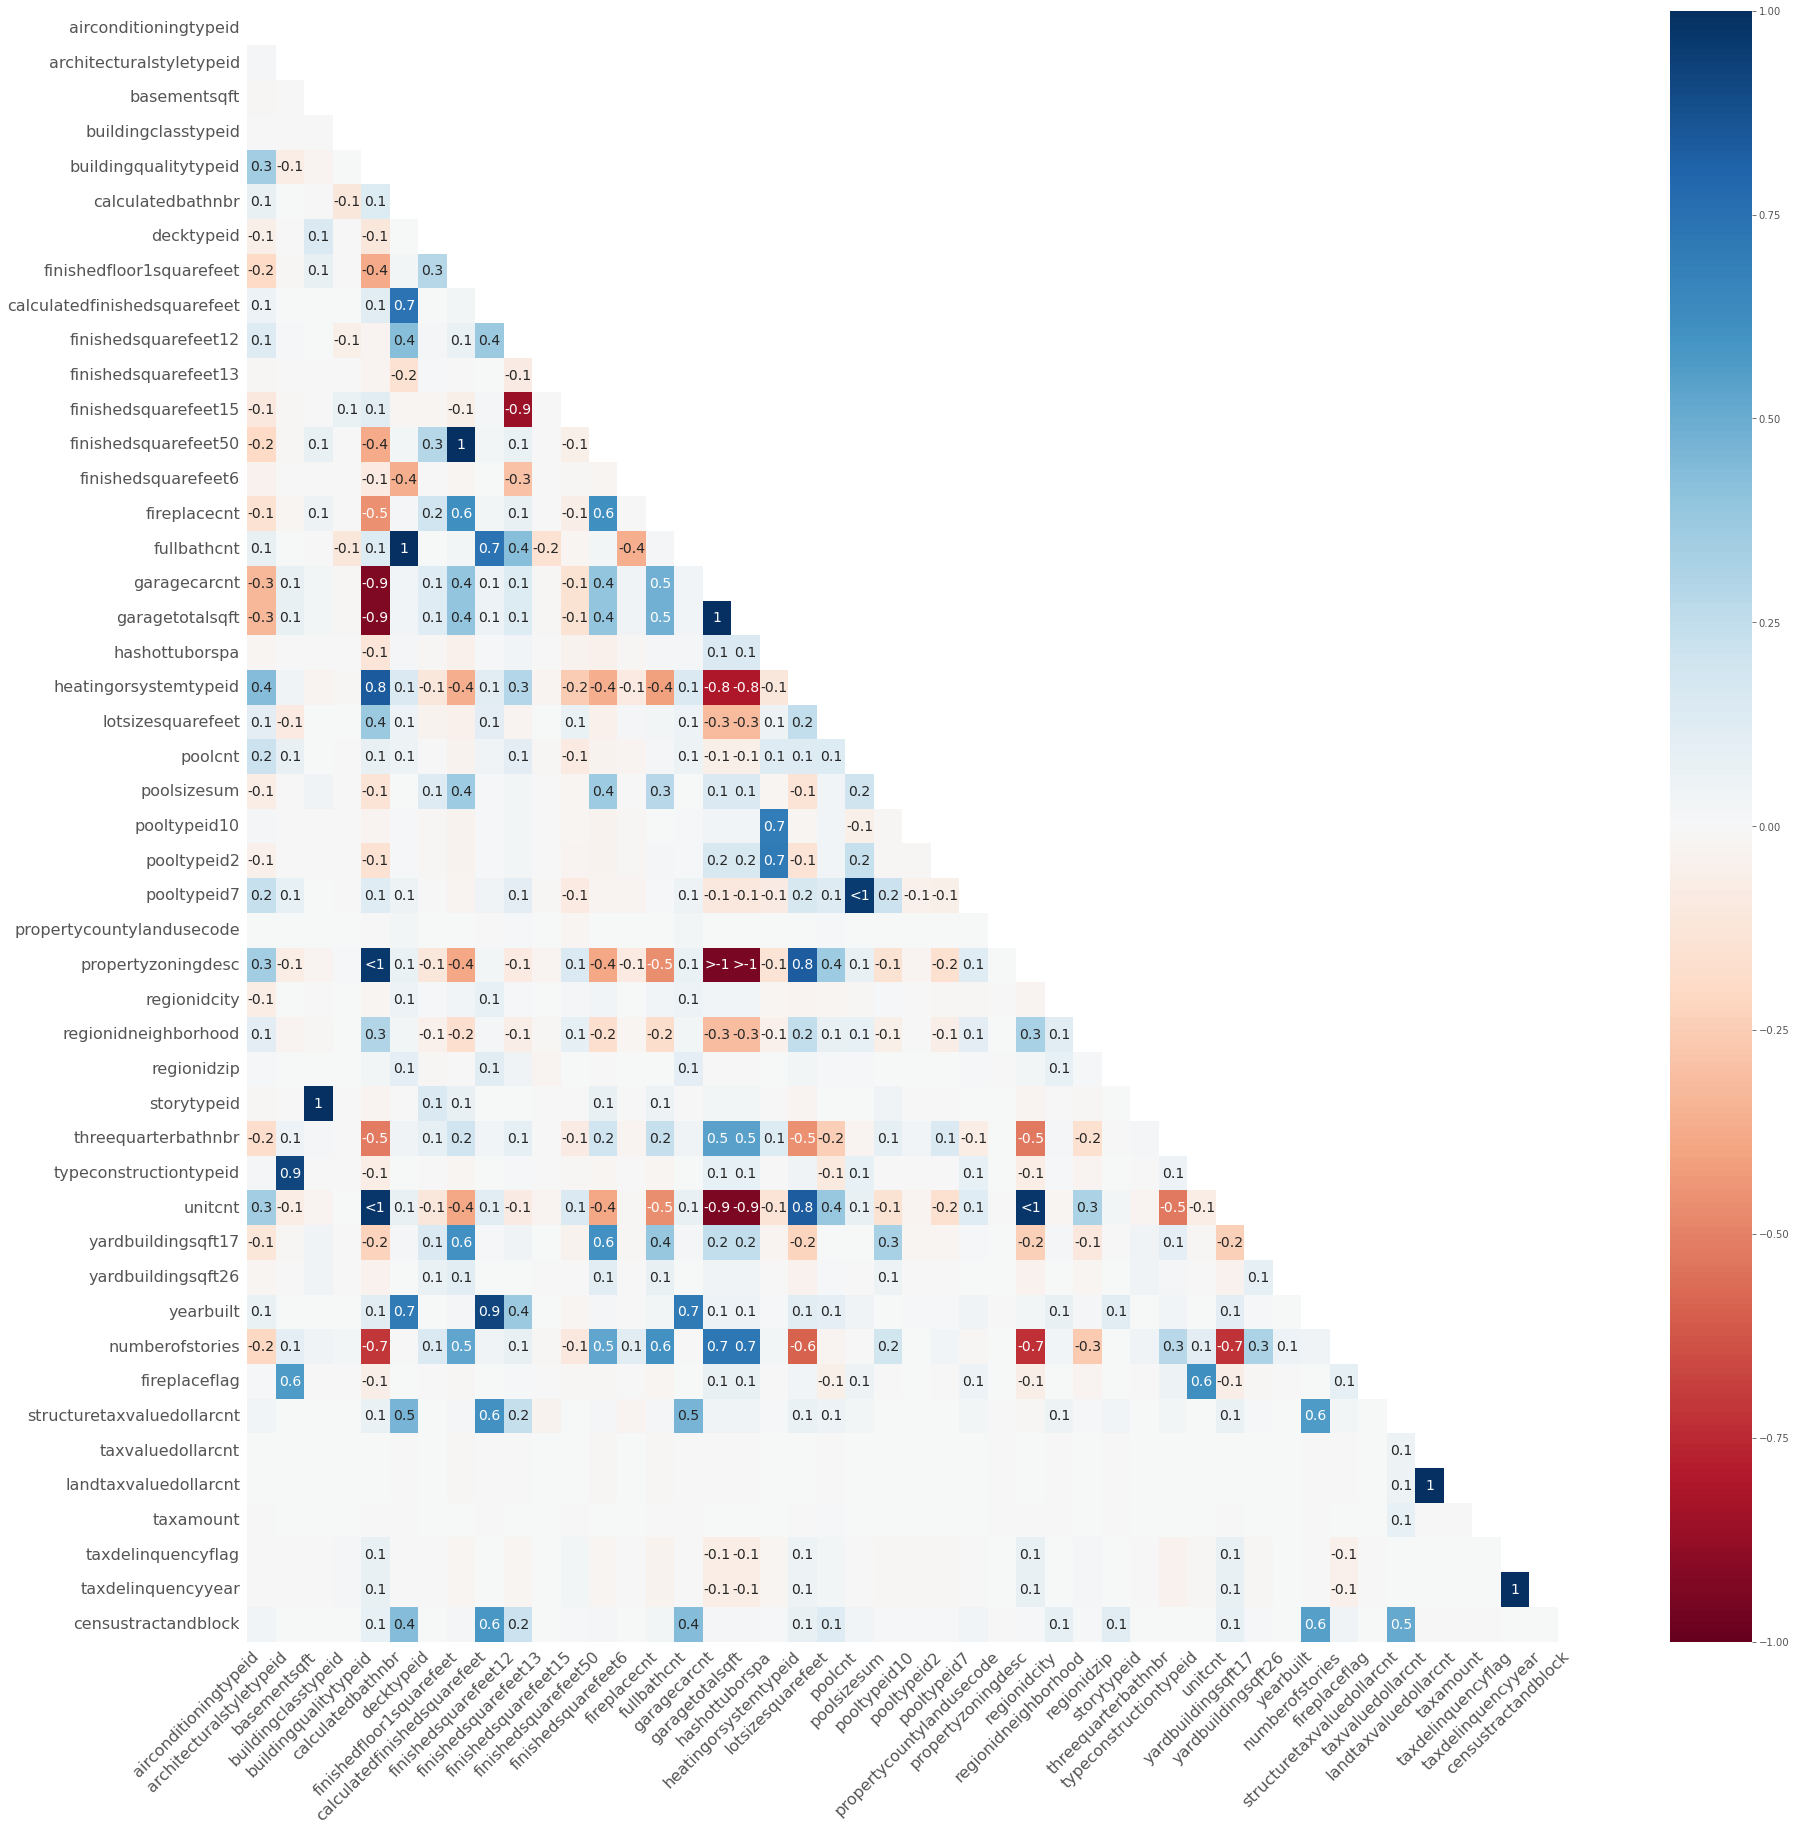

In [97]:
def missing_values_heatmap(dataset):
    missingValueColumns = dataset.columns[dataset.isnull().any()].tolist()
    msno.heatmap(dataset[missingValueColumns],figsize=(30,30))
    pass

missing_values_heatmap(data2016)

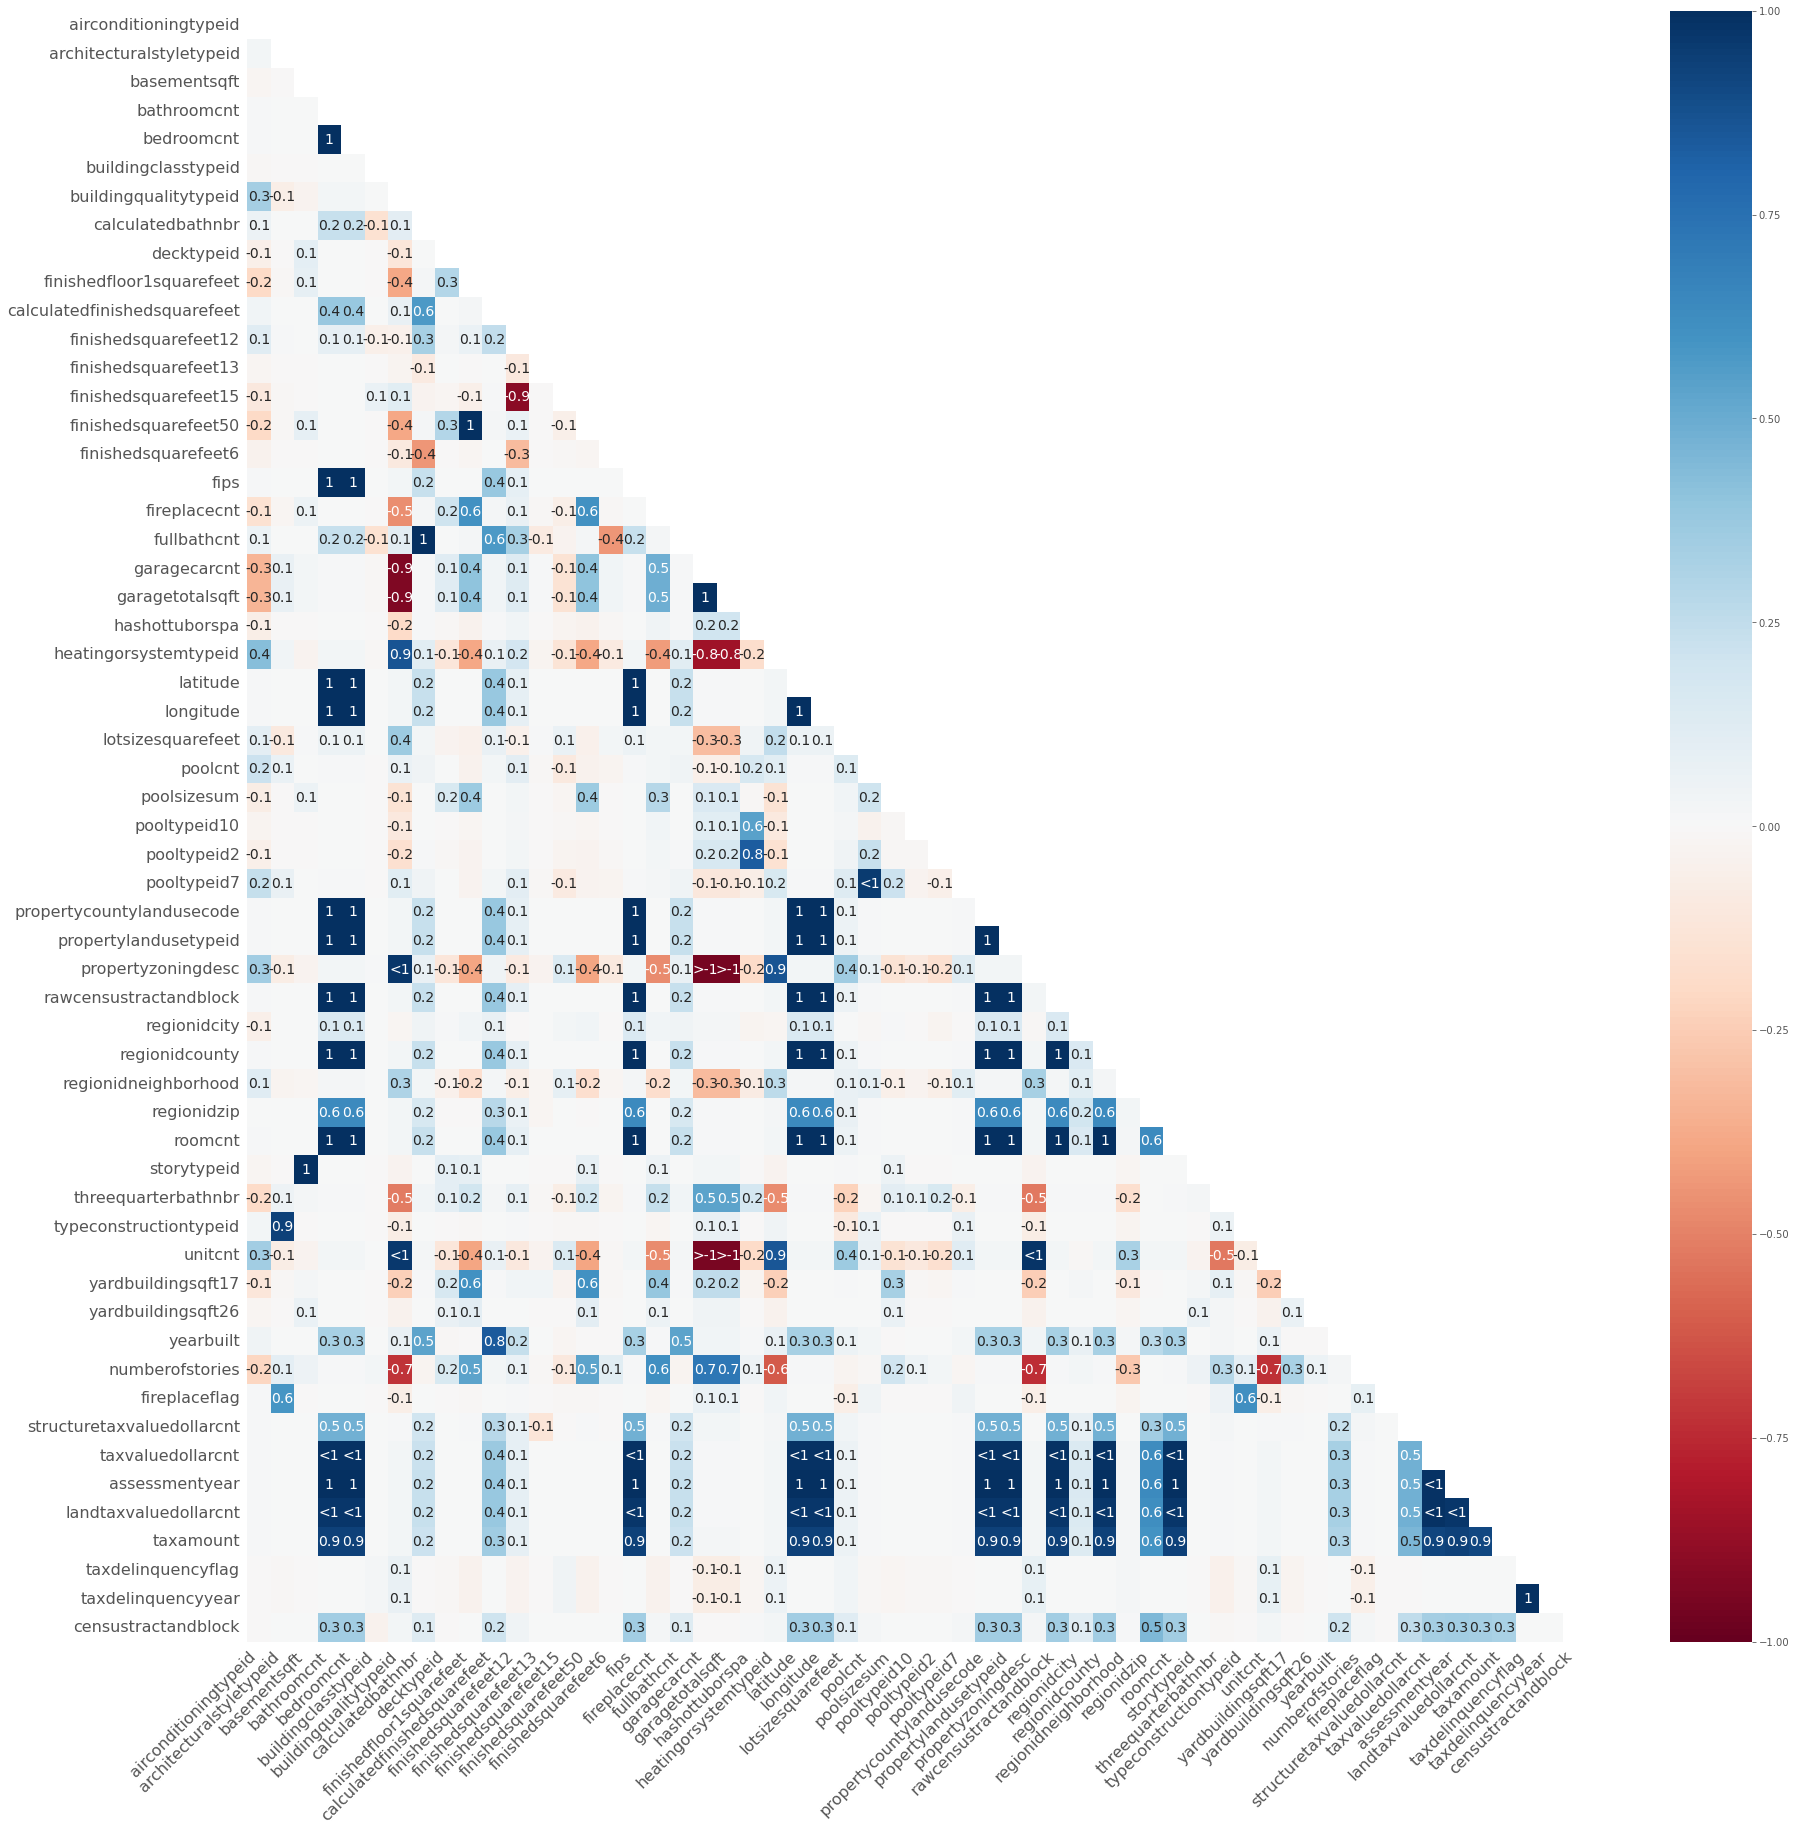

In [98]:
missing_values_heatmap(data2017)

We can see that some feature that are correlated, also are very redundant!

By looking at the claims description they represent very similair pieces of information (the area of the property) lets pick the one with the fewest number of missing values and drop the rest. 

### Step 2.2: LogError Outliers
This step's goal is to identify the presence of eventual outliers and to evaluate the appropriate way to handle them.

The first thing we are going to do is to plot the LogError distribution over the recorded values.

The second thing we are going to do is to plot the frequency of the LogError's values over the recorder values.

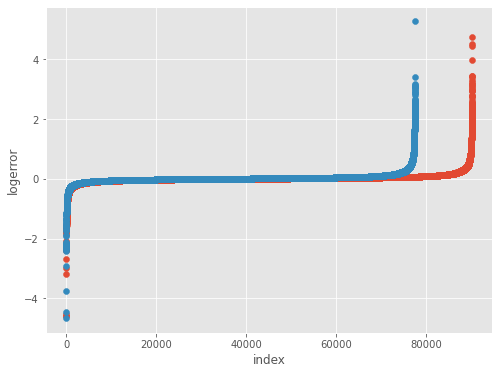

In [99]:
plt.figure(figsize=(8,6))
plt.scatter(range(data2016.shape[0]), np.sort(data2016.logerror.values))
plt.scatter(range(data2017.shape[0]), np.sort(data2017.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

We can say that most of the values of the LogError belong to the interval $[-2,2]$. 

This could be an hint on where to draw the line between normal values and outliers.

Let's visualize the frequency distribution.

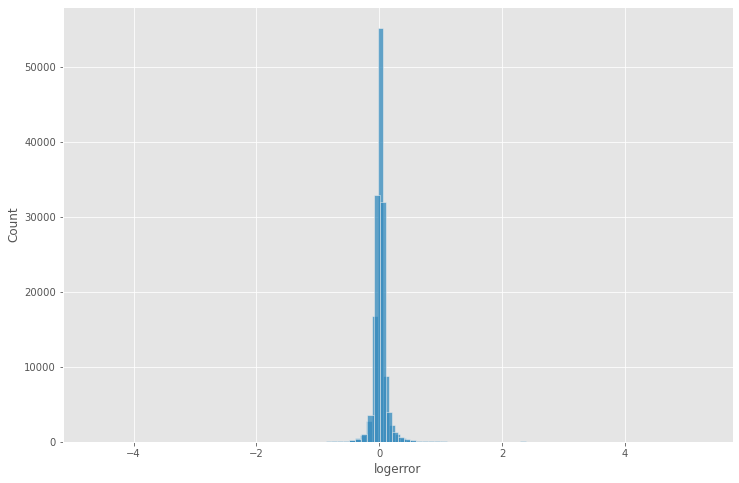

In [100]:
plt.figure(figsize=(12,8))
sns.histplot(data2016.logerror.values, bins=100, kde=False)
sns.histplot(data2017.logerror.values, bins=100, kde=False)
plt.xlabel('logerror', fontsize=12)
# plt.xlim((-4,4))
plt.show()

It is obvious that most of the values belongs to the interval $[-1,1]$.

But, even if it's hard to see it, there are some values that lie in the intervals $[-4,-1]$ and $[1,4]$.

Let's evaluate the entity of the presence of the outliers that belongs in these two intervals. The value will be computed from different increasing spans.

In [101]:
for i in [0.5,1.0,1.5,2.0,2.5,3.0,3.5]:
    print(f"Percentage of outliers, assuming as the regular values interval [-{i},{i}] : {100*(data2016[data2016['logerror'] > i].size + data2016[data2016['logerror'] < -i].size) / data2016.size} %")

Percentage of outliers, assuming as the regular values interval [-0.5,0.5] : 1.3890888950429243 %
Percentage of outliers, assuming as the regular values interval [-1.0,1.0] : 0.3788424259207976 %
Percentage of outliers, assuming as the regular values interval [-1.5,1.5] : 0.1772362226530047 %
Percentage of outliers, assuming as the regular values interval [-2.0,2.0] : 0.12517308224868456 %
Percentage of outliers, assuming as the regular values interval [-2.5,2.5] : 0.03544724453060094 %
Percentage of outliers, assuming as the regular values interval [-3.0,3.0] : 0.01993907504846303 %
Percentage of outliers, assuming as the regular values interval [-3.5,3.5] : 0.007754084741068956 %


It's clear that the more we widen the interval of regular values, the less they are relevant.

We also need to consider that the LogError measure involves the use of the logarithm, so the presence of these values is not necessarily correlated to a problem of any kind. Even if we consider the presence of this values, the distribution curve appears to be nicely normal. Therefore, for the moment, no action will be taken.

## Step 3: Cleaning and Feature Engineering

We are going to create additional features to better direct our predictions.

#### A feature problem

Some of these columns are not useful for our purpose, this is why after an extensive research we understood the main driving factors for house prices:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market and economic change
8. Mortgage interest rate

However, we do not have data for each one of those points and most of them are hard to represent in the way the datasets are given to us (even if wanted to add some features of our own).

We have to face some difficult decisions now, which will mainly concern
* Type Conversion
* Rescaling
* Dropping Values
    * Outliers
    * Empty Columns
* Artificial Filling (if over 60%)

### Step 3.1:  Additional features related to the property

In [102]:
#Binding the dataset to a new name
df_train = data2016

In [103]:
#life of property
df_train['N-life'] = 2022 - df_train['yearbuilt']

#error in calculation of the finished living area of home
df_train['N-LivingAreaError'] = df_train['calculatedfinishedsquarefeet']/df_train['finishedsquarefeet12']

#proportion of living area
df_train['N-LivingAreaProp'] = df_train['calculatedfinishedsquarefeet']/df_train['lotsizesquarefeet']
df_train['N-LivingAreaProp2'] = df_train['finishedsquarefeet12']/df_train['finishedsquarefeet15']

#Amout of extra space
df_train['N-ExtraSpace'] = df_train['lotsizesquarefeet'] - df_train['calculatedfinishedsquarefeet'] 
df_train['N-ExtraSpace-2'] = df_train['finishedsquarefeet15'] - df_train['finishedsquarefeet12'] 

#Total number of rooms
df_train['N-TotalRooms'] = df_train['bathroomcnt']*df_train['bedroomcnt']

#Average room size
df_train['N-AvRoomSize'] = df_train['calculatedfinishedsquarefeet']/df_train['roomcnt'] 

# Number of Extra rooms
df_train['N-ExtraRooms'] = df_train['roomcnt'] - df_train['N-TotalRooms'] 

#Ratio of the built structure value to land area
df_train['N-ValueProp'] = df_train['structuretaxvaluedollarcnt']/df_train['landtaxvaluedollarcnt']

#Does property have a garage, pool or hot tub and AC?
df_train['N-GarPoolAC'] = ((df_train['garagecarcnt']>0) & (df_train['pooltypeid10']>0) & (df_train['airconditioningtypeid']!=5))*1 

df_train["N-location"] = df_train["latitude"] + df_train["longitude"]
df_train["N-location-2"] = df_train["latitude"]*df_train["longitude"]
df_train["N-location-2round"] = df_train["N-location-2"].round(-4)

df_train["N-latitude-round"] = df_train["latitude"].round(-4)
df_train["N-longitude-round"] = df_train["longitude"].round(-4)

#### Step 3.1.2:  Additional features based off the tax related variables

In [104]:
#Ratio of tax of property over parcel
df_train['N-ValueRatio'] = df_train['taxvaluedollarcnt']/df_train['taxamount']

#TotalTaxScore
df_train['N-TaxScore'] = df_train['taxvaluedollarcnt']*df_train['taxamount']

#polnomials of tax delinquency year
df_train["N-taxdelinquencyyear-2"] = df_train["taxdelinquencyyear"] ** 2
df_train["N-taxdelinquencyyear-3"] = df_train["taxdelinquencyyear"] ** 3

#Length of time since unpaid taxes
df_train['N-life'] = 2018 - df_train['taxdelinquencyyear']

#### Step 3.1.3: Other features based off the location

In [105]:
#Number of properties in the zip
zip_count = df_train['regionidzip'].value_counts().to_dict()
df_train['N-zip_count'] = df_train['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = df_train['regionidcity'].value_counts().to_dict()
df_train['N-city_count'] = df_train['regionidcity'].map(city_count)

#Number of properties in the city
region_count = df_train['regionidcounty'].value_counts().to_dict()
df_train['N-county_count'] = df_train['regionidcounty'].map(city_count)

#### Step 3.1.4: Additional variables which are simplification of some of the other variables

In [106]:
#Indicator whether it has AC or not
df_train['N-ACInd'] = (df_train['airconditioningtypeid']!=5)*1

#Indicator whether it has Heating or not 
df_train['N-HeatInd'] = (df_train['heatingorsystemtypeid']!=13)*1

#There's 25 different property uses - let's compress them down to 4 categories
df_train['N-PropType'] = df_train.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })

#### Step 3.1.5: Extra
One of the EDA kernels indicated that structuretaxvaluedollarcnt was one of the most important features. 
So let's create some additional variables on that.

In [107]:
#polnomials of the variable
df_train["N-structuretaxvaluedollarcnt-2"] = df_train["structuretaxvaluedollarcnt"] ** 2
df_train["N-structuretaxvaluedollarcnt-3"] = df_train["structuretaxvaluedollarcnt"] ** 3

#Average structuretaxvaluedollarcnt by city
group = df_train.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
df_train['N-Avg-structuretaxvaluedollarcnt'] = df_train['regionidcity'].map(group)

#Deviation away from average
df_train['N-Dev-structuretaxvaluedollarcnt'] = abs((df_train['structuretaxvaluedollarcnt'] - df_train['N-Avg-structuretaxvaluedollarcnt']))/df_train['N-Avg-structuretaxvaluedollarcnt']

### Step 3.2: Data Cleaning
We need to identify
- Missing data
- Unhelpful features
- Non-numeric data
- Data that needs to be rescaled 

We need to plan
- Featuring engineering
- How to adapt/transform the data

---

To deal with Missing Data:

1st Method: Drop Missing Data
- a. Drop the whole row OR 
- b. Drop the whole column (This should be used ONLY if most entries are empty in your column)

2nd Method: Replace data 
- a. Replace it by mean OR
- b. Replace it by frequency (mode) OR 
- c. Replace it based on other functions

---

In section 1.4 we identified the columns that were missing more than 89% of data. We can start by dropping them.
'propertyzoningdesc' is a feature whose type is string, so in order to keep our models simple we are just going to drop it.

In [108]:
to_drop = to_drop + ['propertyzoningdesc']
df_train = df_train.drop(columns=to_drop, axis = 1)

Now that we have removed the less significant part of the dataset, we can now proceed to fill the columns' cells whose missing data ratio is over 60%.

#### Step 3.2.1 Features with missing data percentage above 60% 

In [109]:
to_fill = missing_ratio[missing_ratio>=0.6].index.tolist() # list of columns to fill
to_fill = list(set(to_fill) - set(to_drop)) # we don't need to consider the dropped columns

for col in to_fill:
    print(f"[{col}] {' ' * (23 - len(col) - 2)}-> {missing_ratio[col]}")

[poolcnt]               -> 0.8017058986430352
[garagetotalsqft]       -> 0.6683799501523123
[airconditioningtypeid] -> 0.681185267238992
[threequarterbathnbr]   -> 0.8669731376350042
[regionidneighborhood]  -> 0.6010855718637497
[pooltypeid7]           -> 0.8150429243976738
[numberofstories]       -> 0.7721406812517309
[garagecarcnt]          -> 0.6683799501523123


These features need to be filled in some way. Let's start with some quick fixes:
- 'poolcnt' is the number of pools located in the considered house. It's pretty safe to assume that if the data is missing, probably there are none, so we could just fill these cells with a 0.

- 'pooltypeid7', similarly as the previous feature, we can assume that the missing value means that there's no pool. In fact, the missing value percentage is similar to the previous one. In this case, this feature signals if the pool has an hot tub or not. We will fill the cells with the value -1, that means "no hot tub".

- 'garagecarcnt' is the number of garages that are present on the lot. As we previously did, we are going to assume that a missing value means that there are none. The empty cells are going to be filled with 0.

- 'garagetotalsqft' represents the surface occupied by the garages. The missing values percentage is the same as 'garagecarcnt', so we are going to fill the empty cells with 0, because we are assuming that that's the meaning of a missing value.

- 'airconditioningtypeid' presents the same situation we have discussed for the previous features. In this case, we are going to fill the empty cells with the value 5, that represents the absence of an air-conditioning system. 

In [110]:
df_train['poolcnt'] = df_train['poolcnt'].fillna(0) #filling the empty cells of 'poolcnt'
df_train['pooltypeid7'] = df_train['pooltypeid7'].fillna(-1) #filling the empty cells of 'pooltypeid7'
df_train['garagecarcnt'] = df_train['garagecarcnt'].fillna(0) #filling the empty cells of 'garagecarcnt'
df_train['garagetotalsqft'] = df_train['garagetotalsqft'].fillna(0) #filling the empty cells of 'garagetotalsqft'
df_train['airconditioningtypeid'] = df_train['airconditioningtypeid'].fillna(5) #filling the empty cells of ''

The remaining features need some considerations before doing any operation on them.
- 'regionidneighborhood' does not represent a property of the house itself, but an id assigned by the local administration. It will be reasonable to fill these missing values with the mean of the values of the literal neighbors. An implementation of the k-NN algorithm may come at hand. The k parameter can be set as 10.

- 'numberofstories' reprents the number of stories of the house. Usually, the houses of a neighborhood do not differ significantly from each others. As we saw for the previuous feature, it may be useful to use the k-NN algorithm to fill the empty cells of this column, basing on the geografic location and the architechtural style of the house. 



In [111]:
def k_NN_filling(to_predict, to_train, k):
    #selecting the training features that we need
    train_x = df_train[to_train]
    train_y = df_train[to_predict]
    to_transform = to_train + to_predict
    # define imputer
    imputer = KNNImputer()
    # fit on the dataset
    imputer.fit(df_train[to_transform])
    # transform the dataset
    df_train[to_transform] = imputer.transform(df_train[to_transform])

<AxesSubplot:>

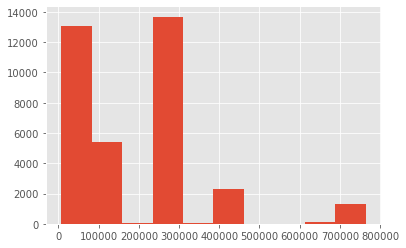

In [112]:
df_train['regionidneighborhood'].hist() #Before the filling

In [113]:
#Filling for 'regionidneighborhood'
regionidneighborhood_to_predict = ['regionidneighborhood']
regionidneighborhood_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=regionidneighborhood_to_predict, to_train=regionidneighborhood_to_train, k=10)


<AxesSubplot:>

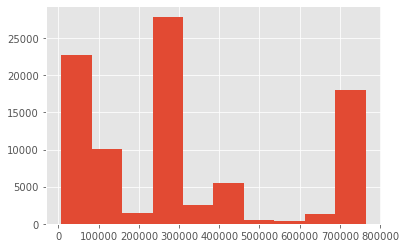

In [114]:
df_train['regionidneighborhood'].hist() #After the filling

In [115]:
#Filling for 'numberofstories'
numberofstories_to_predict = ['numberofstories']
numberofstories_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=numberofstories_to_predict, to_train=numberofstories_to_train, k=10)

#### Step 3.2.2 Features with missing data percentage below 60% 
We will now proceed with the managing the other features. We will now consider the ones whose missing data percentage is below 60%. Due to time-economy reasons, we will consider just the ones whose percentage is above 5%.

In [116]:
to_fill_5p = missing_ratio[missing_ratio>=0.05].index.tolist() # list of columns to fill, above 5%
to_fill_5p = list(set(to_fill_5p) - set(to_drop) - set(to_fill)) # we don't need to consider the other columns

for col in to_fill_5p:
    print(f"[{col}] {' ' * (25 - len(col) - 2)}-> {missing_ratio[col]}")

[buildingqualitytypeid]   -> 0.3645638327333149
[finishedsquarefeet12]    -> 0.05183051786208807
[unitcnt]                 -> 0.353608418720576
[heatingorsystemtypeid]   -> 0.3787870396012185
[lotsizesquarefeet]       -> 0.11243422874549987


Let's see what can be done with these features:

- 'heatingorsystemtypeid' represents an id for the type of heating system present in the house. Like we did before with 'garagecarcnt', it's safe to assume that it is not present if the value is missing. Therefore, any missing value will be filled with 13, that is the id for "None".

- 'unitcnt' is the number of unit that belong to the lot. It will be filled with the median value for this column.

- 'lotsizesquarefeet' is the total area of the lot in square feet. Like we did for the previous features, we will fill the missing values with the k-NN algorithm, basing our predictions on te geographic location of the lot. The k parameter will be mantained as 10.

- 'buildingqualitytypeid' is an index that represents an assessment of condition of the building. We are going to assume that the missing values' lots will be the mean value condition.

- 'finishedsquarefeet12' is the total surface of the living area of the lot. It's hard to assume anything on this feature. Since the percentage of missing values is low, we can just drop the rows that present missing values.



In [117]:
df_train['heatingorsystemtypeid'] = df_train['heatingorsystemtypeid'].fillna(13)
df_train['unitcnt'] = df_train['unitcnt'].fillna(df_train['unitcnt'].median())
df_train['buildingqualitytypeid'] = df_train['buildingqualitytypeid'].fillna(df_train['buildingqualitytypeid'].mean())
df_train = df_train.dropna(axis=0, subset=['finishedsquarefeet12'])

In [118]:
#Filling for 'lotsizesquarefeet'
lotsizesquarefeet_to_predict = ['lotsizesquarefeet']
lotsizesquarefeet_to_train   = ['latitude','longitude']
k_NN_filling(to_predict=lotsizesquarefeet_to_predict, to_train=lotsizesquarefeet_to_train, k=10)

### Step 3.3 DataType conversions
It's important to convert the data in a format that allows to achieve a consisistent state of the dataset. What follows is a list of all the data types present in the dataset. 
The following snippet will print the aforementioned list.
We are going to collect the 'object' features for later use.

#### Step 3.3.1 DataType 

In [119]:
type_list = df_train.dtypes.to_list()
objects = []
for i in range(len(list(df_train.columns))):
    print(f"[{df_train.columns[i]}]: {' ' * (35- len(df_train.columns[i]) - 2)} {type_list[i]}")
    if type_list[i] == object:
        objects.append(df_train.columns[i])

[parcelid]:                           int64
[airconditioningtypeid]:              float64
[bathroomcnt]:                        float64
[bedroomcnt]:                         float64
[buildingqualitytypeid]:              float64
[calculatedbathnbr]:                  float64
[calculatedfinishedsquarefeet]:       float64
[finishedsquarefeet12]:               float64
[fips]:                               float64
[fullbathcnt]:                        float64
[garagecarcnt]:                       float64
[garagetotalsqft]:                    float64
[heatingorsystemtypeid]:              float64
[latitude]:                           float64
[longitude]:                          float64
[lotsizesquarefeet]:                  float64
[poolcnt]:                            float64
[pooltypeid7]:                        float64
[propertycountylandusecode]:          object
[propertylandusetypeid]:              float64
[rawcensustractandblock]:             float64
[regionidcity]:                      

After the discovery of the type of the remaining features, we are going to convert the ones that have 'object' as type.
First of all, let's see who they are:

In [120]:
objects

['propertycountylandusecode', 'transactiondate', 'N-PropType']

It is important that 'transactiondate' is handled by itself, so we are going to remove it from the list.
Now, we can convert these features' types to more appropriate ones, by using the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) object, provided by sklearn.

In [121]:
def object_encoding(feature):
    lbl = LabelEncoder()
    lbl.fit(list(feature.values))
    return lbl.transform(list(feature.values))

objects = list(set(objects) - set(['transactiondate']))

print(objects)

for col in objects:
    df_train[col] = object_encoding(df_train[col])

['propertycountylandusecode', 'N-PropType']


#### Step 3.3.2 Transaction Date type conversion
The Date Type cannot be usually read by the classifiers and the predictors. After we have handled this feature, we are going to drop it. We can do it here, since it has no missing values, so it does not need further cleaning.

Since it's hard to predict which is the best way to manipulate this information, we are going to add some new features that will allow us to have more than one option when it comes to assessing the importance of the features.

What follows is a list of new features that we can derive from the transaction date. Then, we will proceed to implement them.

- 'NDaysInCurrentYear', the number of days from January 1st.

- 'DD', the day of the month.

- 'MM', the month of the year.

- 'YY', the year.

By looking at [this article](https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/), it looks like there are a lot more of options available. But, since we are trying to keep this model as simple as possible, we will ignore them.

In [134]:
df_train['DD'] = df_train['transactiondate'].str.replace("-","").astype(int)
df_train['DD'] = df_train['DD'].apply(lambda r: r % 100)
df_train['MM'] = df_train['transactiondate'].str.replace("-","").astype(int)
df_train['MM'] = df_train['MM'].apply(lambda r: (r - (r % 100)) / 100)
df_train['YY'] = df_train['transactiondate'].str.replace("-","").astype(int)
df_train['YY'] = df_train['YY'].apply(lambda r: (r - (r % 10000)) / 10000)

df_train['N-DaysInCurrentYear'] = df_train['transactiondate'].apply(lambda r: pd.Period(r).day_of_year)

## Step 4: Development and Modeling
This step involves presenting
the dataset to the target audience in the form of graphs, summary tables, maps,
and diagrams.

#### Step 4.1: Asserting feature importance
Lets use XGBoost to assess importance

In [153]:
train_y = df_train['logerror'].values
df_assess = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
feat_names = df_train.columns.values

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_assess, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), df_assess, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

XGBoostError: [22:39:34] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:1163: Check failed: valid: Input data contains `inf` or `nan`

In [ ]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sns.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

### Step 4.2: Focus on logerror

In [ ]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values)) 
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(["parcelid", "transactiondate", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

In [ ]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

In [ ]:
### 4.2.1: TP Correlation

In [ ]:
topFeatures = features["features"].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

### 4.3: Multicollineraity analysis
In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation, the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


numericalCol = []
for f in merged.columns:
    #print (f)
    if merged[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#34495e")
sn.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h",color="#34495e")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

### Step 4.4 Top Features Selection

In [ ]:
# Target variable for this competition is "logerror" field. 
# So let us do some analysis on this field first.

plt.figure(figsize=(8,6))
plt.scatter(range(data2016.shape[0]), np.sort(data2016.logerror.values))
plt.scatter(range(data2017.shape[0]), np.sort(data2017.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [ ]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].ix[merged['logerror']>ulimit] = ulimit
merged['logerror'].ix[merged['logerror']<llimit] = llimit

fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.distplot(merged.logerror.values, bins=50,kde=False,color="#34495e",ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score',title="Distribution Of Dependent Variable")

## Step 5: Cross Validation & Export

### Cross Validation
The threat of overfitting is always behind the corner. 

Overfitting is the low predictive power of the model, caused by the use of the same dataset for the training phase and the testing phase. Since the goal of the model is to "adapt" to the data on which it trains on, testing its accuracy on the same dataset would lead to some unaccurate results.

For this reason, we adopted the cross validation, which is a technique that prevents this phenomenon. 

We chose to split the dataset using the k-fold algorithm, by using the library provided by [Scikitlearn](https://https://scikit-learn.org/stable/modules/cross_validation.html).

This method consist in splitting the dataset in k groups (the "folds") and keeping one out as the testing set. This procedure is repeated for each one of the folds, in order to minimize the chances of overfitting. The value we chose for k is 5, since it's the default one due to its high use.

Since we dispose of two main datasets, one for the year 2016 and one for the year 2017, we will apply the k-fold algorithm on both of them, and cross the resulting folds to maximize the randomness of the test.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold()

df_train_folded16, df_test_folded16 = [], []
df_train_folded17, df_test_folded17 = [], []


for train_index, test_index in kf.split(df_train16):
  df_train_folded16.append(df_train16[train_index])
  df_test_folded16.append(df_train16[train_test])

for train_index, test_index in kf.split(df_train17):
  df_train_folded17.append(df_train17[train_index])
  df_test_folded17.append(df_train17[train_test])


### Exporting the cleaned dataset

The following snippet will export the cleaned dataset in a series of file containing the testing and training dataset.



In [ ]:
#2016 dataset
i = 0
for ds in df_train_folded16:
  i += 1
  ds.to_csv(f"Data/train_dataset_2016_{i}")

i = 0
for ds in df_test_folded16:
  i += 1
  ds.to_csv(f"Data/test_dataset_2016_{i}")


In [ ]:
#2017 dataset
i = 0
for ds in df_train_folded17:
  i += 1
  ds.to_csv(f"Data/train_dataset_2017_{i}")

i = 0
for ds in df_test_folded17:
  i += 1
  ds.to_csv(f"Data/test_dataset_2017_{i}")


##### Credits
Credits go to: 
[Simple Exploration Notebook](https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-zillow-prize)
[Zillow analysis with EDA🏠](https://www.kaggle.com/code/hyewon328/zillow-analysis-with-eda)
[Zillow EDA On Missing Values & Multicollinearity](https://www.kaggle.com/code/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity)
[Creating Additional Features](https://www.kaggle.com/code/nikunjm88/creating-additional-features)
[Simple EDA Geo Data & Time Series](https://www.kaggle.com/code/kueipo/simple-eda-geo-data-time-series)
[Carefully dealing with missing values](https://www.kaggle.com/code/nikunjm88/carefully-dealing-with-missing-values)